# Explaining cortical thickness development: Modelled colocalization trajectories

In [1]:
import os
from os.path import join
import sys

import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import seaborn as sns
from skmisc.loess import loess

# custom functions
from scripts.templates import get_destrieux

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from juspyce.plots import hide_empty_axes

# centile predictions path
rutherford_dir = join(wd, "data_rutherford")

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directory
plot_dir = join(wd, "plots", "colocalization")

Working directory: /Users/llotter/projects/ntct


## Get data

### Get predictor data

In [2]:
# predictor data
predictors_destrieux = pd.read_csv(join(predictor_dir, 'data_factors_destrieux.csv'), index_col=0)
predictors = list(predictors_destrieux.columns)

# parcellation
parc_destrieux, destrieux_idps = get_destrieux()

### Cortex development data

In [3]:
# GET CT DATA --------------------------------------------------------------------------------------

predicted_ct_f = np.load(join(rutherford_dir, "ct_predicted_f.npy"))
predicted_ct_m = np.load(join(rutherford_dir, "ct_predicted_m.npy"))

parcels_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_parcels.txt"), str))
cent_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_centiles.txt")))
tp_ct = list(np.loadtxt(join(rutherford_dir, "ct_predicted_tps.txt")))

# collect ct data in 2d dataframes for each centile restricted to relevant age range
predicted_ct_f_dict, predicted_ct_m_dict = dict(), dict()

for i, c in enumerate(cent_ct):
    predicted_ct_f_dict[c] = pd.DataFrame(
        data=predicted_ct_f[:,:,i].T, 
        index=tp_ct, 
        columns=parcels_ct)\
            .loc[np.arange(5,90.1,0.5),:]
    predicted_ct_m_dict[c] = pd.DataFrame(
        data=predicted_ct_m[:,:,i].T, 
        index=tp_ct, 
        columns=parcels_ct)\
            .loc[np.arange(5,90.1,0.5),:]
# reshape using 2d index
predicted_ct_f_df = pd.concat(predicted_ct_f_dict, axis=0, names=["cent", "tp"]) 
predicted_ct_m_df = pd.concat(predicted_ct_m_dict, axis=0, names=["cent", "tp"]) 

# average between females and males
predicted_ct_fm_df = (predicted_ct_f_df + predicted_ct_m_df) / 2
    
# dimensions
n_tp_ct, n_parcels_ct = predicted_ct_f_dict[0.5].shape

# check --------------------------------------------------------------------------------------------

print(f"Shape predictors_destrieux: parcels x atlases {predictors_destrieux.shape}")

print(f"Shape predicted_ct: parcels x timepoints x centiles {predicted_ct_f.shape}")
print(f"Shape predicted_ct_f_dict: timepoints x parcels {predicted_ct_f_dict[0.5].shape}")
print(f"Shape predicted_ct_fm_df: (centiles x timepoints) x parcels {predicted_ct_fm_df.shape}")

Shape predictors_destrieux: parcels x atlases (148, 21)
Shape predicted_ct: parcels x timepoints x centiles (148, 230, 7)
Shape predicted_ct_f_dict: timepoints x parcels (171, 148)
Shape predicted_ct_fm_df: (centiles x timepoints) x parcels (1197, 148)


## Development of cortex - predictor correlations

In [4]:
# initialize & import data
juspyce_spearman = dict()
for sex, target in zip(["f", "m", "fm"],
                       [predicted_ct_f_df, predicted_ct_m_df, predicted_ct_fm_df]):
            
    # initialize juspyce
    juspyce_spearman[sex] = JuSpyce(x=predictors_destrieux.T,
                            y=target,
                            data_space="fsaverage",
                            parcellation=parc_destrieux,
                            parcellation_space="fsaverage",
                            parcellation_density="10k",
                            standardize=False,
                            drop_nan=False,
                            n_proc=-1).fit()
    # correlate
    juspyce_spearman[sex].predict(method="spearman", r_to_z=True)
    # save data as juSpyce object
    juspyce_spearman[sex].to_pickle(join(wd, "data_rutherford", f"juspyce_ct_spearman_{sex}.pkl.gz"))

INFO:scripts.juspyce.api:Checking input data for x (should be, e.g., PET data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'x' data for 21 x 148 parcels.
INFO:scripts.juspyce.api:Checking input data for y (should be, e.g., subject data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO:scripts.juspyce.api:Creating deep copy of JuSpyce object.
INFO:scripts.juspyce.api:Saved complete gzip compressed object to /Users/llotter/projects/ntct/data_rutherford/juspyce_ct_spearman_f.pkl.gz.
INFO:scripts.juspyce.api:Checking input data for x (should be, e.g., PET data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'x' data for 21 x 148 parcels.
INFO:scripts.juspyce.api:Checking input data for y (should be, e.g., subject data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO:scripts.juspyce.api:Creating deep copy of JuSpyce object.
INFO:scripts.juspyce.api:Saved complete gzip compressed object to /Users/llotter/projects/ntct/data_rutherford/juspyce_ct_spearman_m.pkl.gz.
INFO:scripts.juspyce.api:Checking input data for x (should be, e.g., PET data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'x' data for 21 x 148 parcels.
INFO:scripts.juspyce.api:Checking input data for y (should be, e.g., subject data):
INFO:scripts.juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:scripts.juspyce.api:Got 'y' data for 1197 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/1197 [00:00<?, ?it/s]

INFO:scripts.juspyce.api:Creating deep copy of JuSpyce object.
INFO:scripts.juspyce.api:Saved complete gzip compressed object to /Users/llotter/projects/ntct/data_rutherford/juspyce_ct_spearman_fm.pkl.gz.


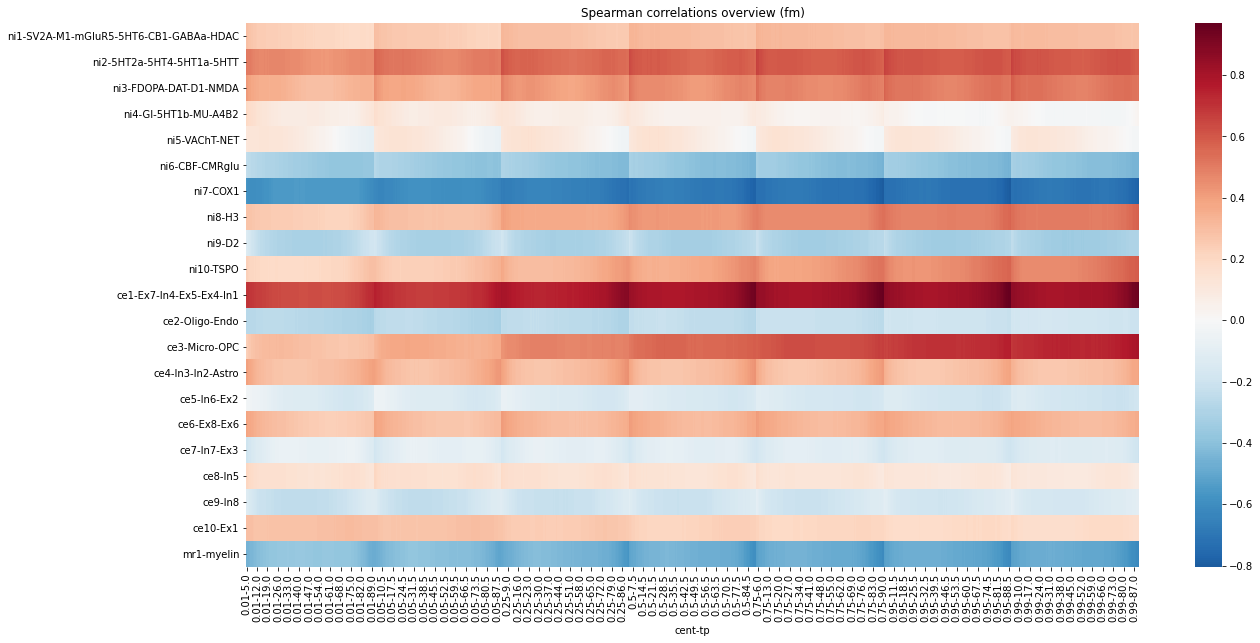

In [5]:
# sanity check: show as heatmap
fig, ax = plt.subplots(1, figsize=(20,10))
sns.heatmap(juspyce_spearman["fm"].predictions["spearman"].T, center=0, cmap="RdBu_r", ax=ax)
_ = ax.set_title(f"Spearman correlations overview (fm)")

## Plot

### Development of CT correlations

In [6]:
# If this is rerun and single-subject data is not available (i.e., if you downloaded this file from 
# GitHub), you will have to set 'plot_scatter' to False.
plot_scatter = True
cut_scatter_y = True

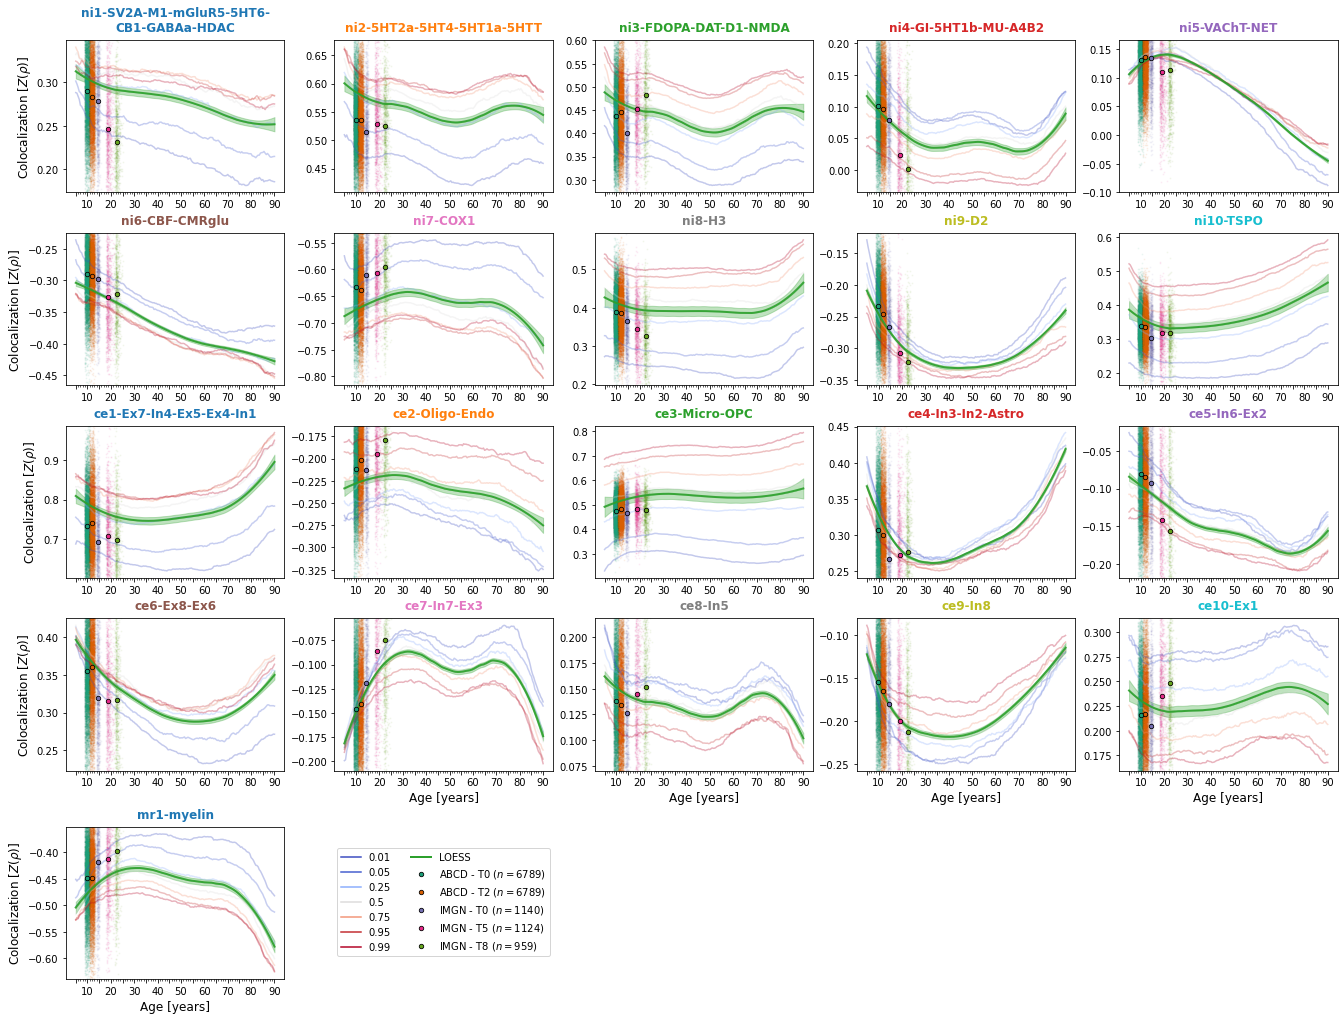

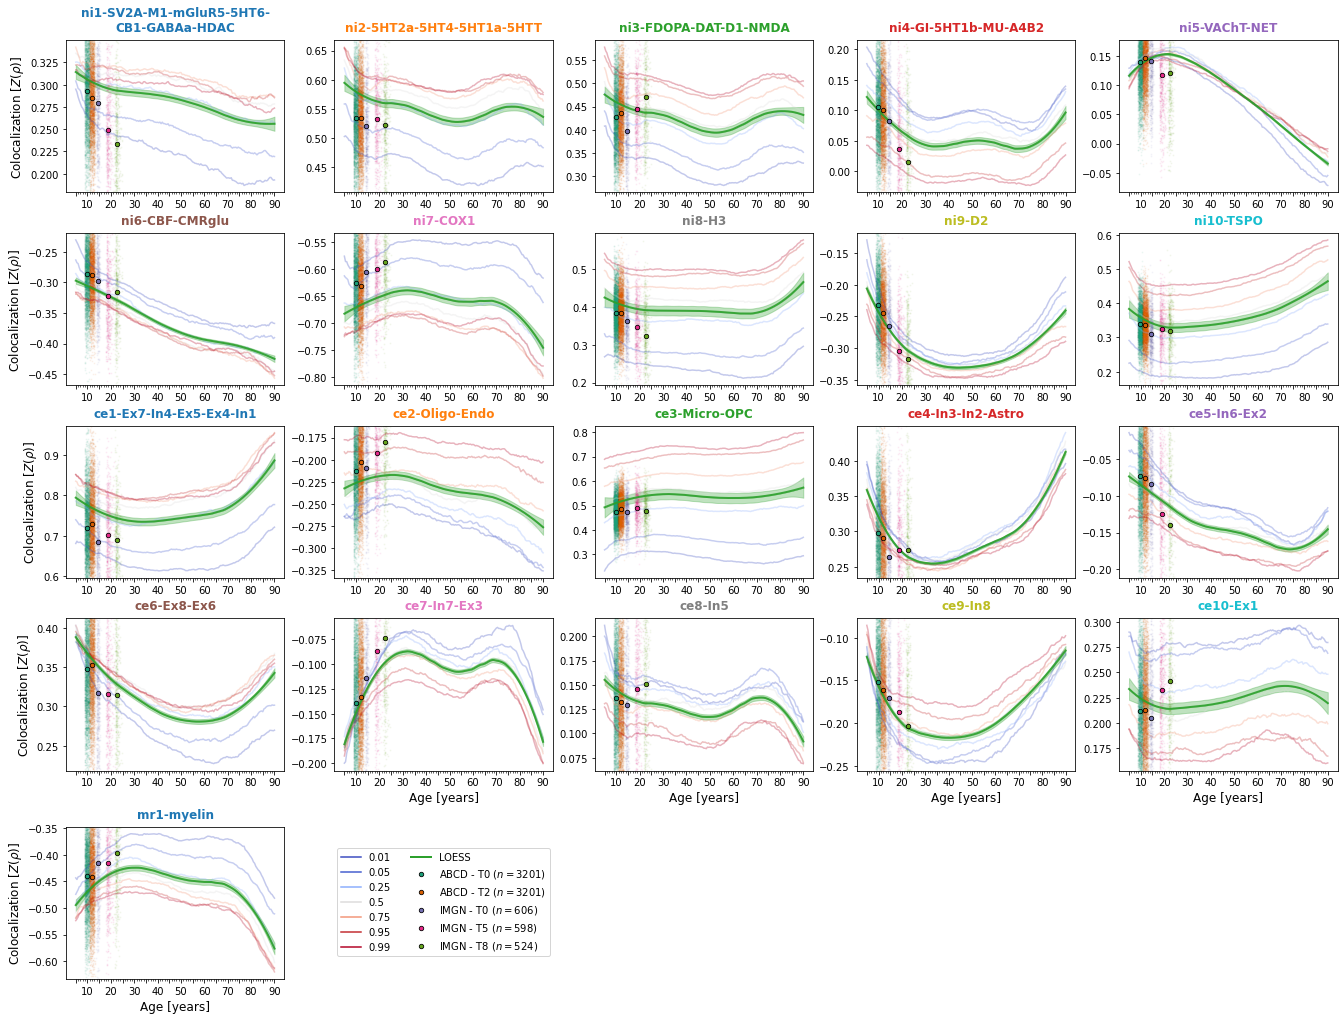

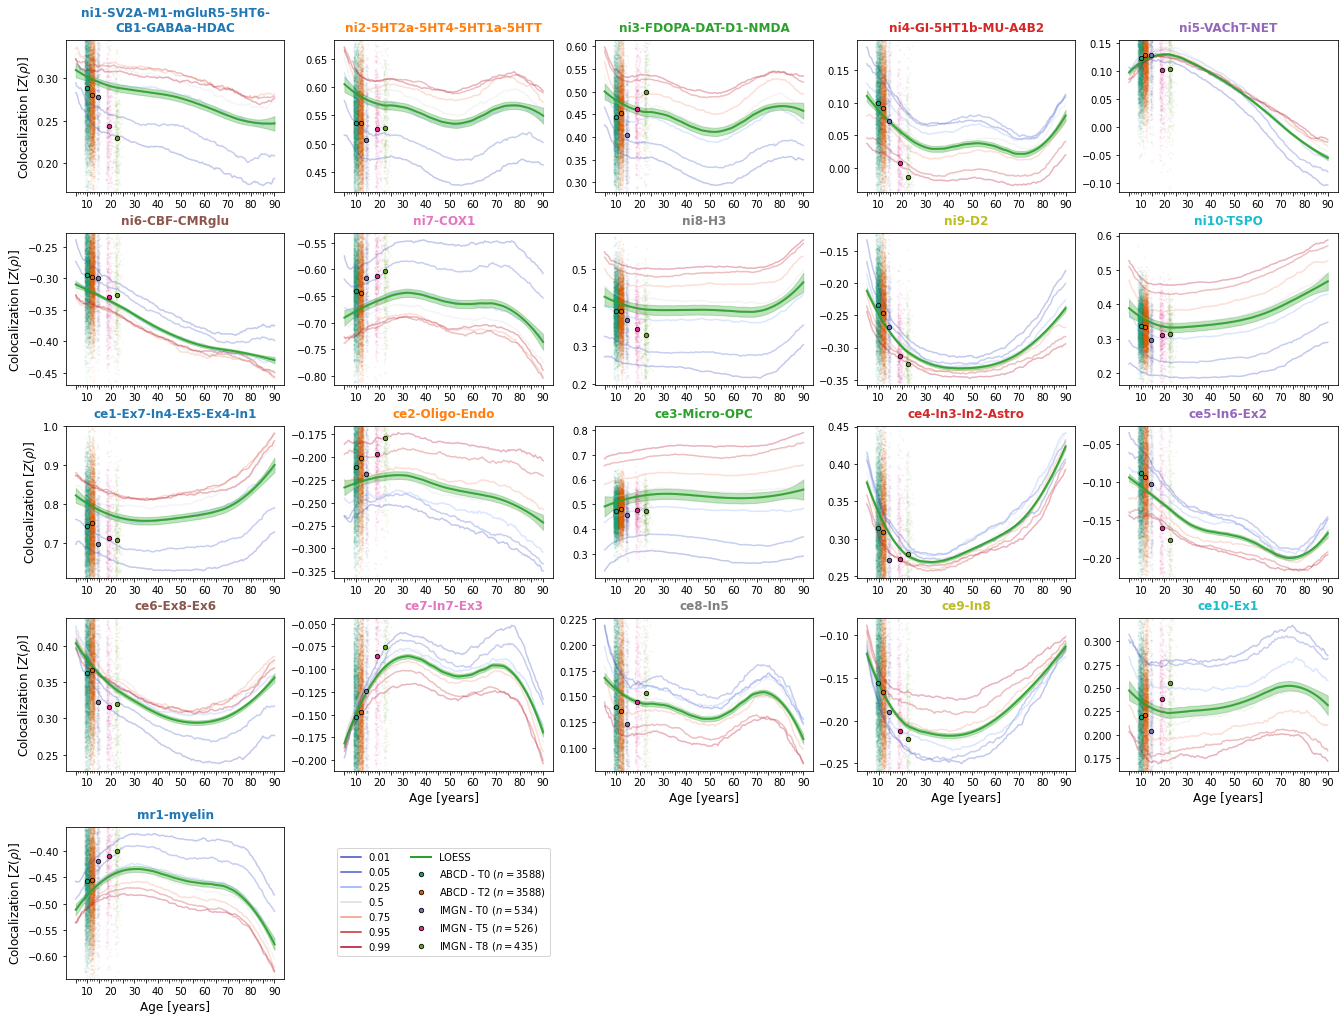

In [7]:
if plot_scatter:
    # single subject data
    res_cross = pd.read_feather(join(wd, "data_ABCD-IMGN", "res_cross.ftr")) \
        .set_index(["ds", "id", "tp", "analysis"]).sort_index()
    imgn = pd.read_feather(join(wd, "data_ABCD-IMGN", "imgn.ftr")) \
        .set_index(["id", "tp"], drop=False).sort_index()
    abcd = pd.read_feather(join(wd, "data_ABCD-IMGN", "abcd.ftr")) \
        .set_index(["id", "tp"], drop=False).sort_index()

cent_plot = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
n_cols = 5
n_rows = int(np.ceil(len(predictors)/n_cols))
predictors_tmp = predictors[:4] + [""] + predictors[4:7] + ["mr1-myelin", ""] + predictors[7:-1]
colors = np.r_[get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ni")]))),
               get_cmap("tab10")(range(len([p for p in predictors if p.startswith("ce")]))),
               get_cmap("tab10")(range(1))]

for sex in ["fm", "f", "m"]:
        
    # figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.7*n_cols, 2.8*n_rows), constrained_layout=True)
    axes = axes.ravel()
    
    # colocalization data
    df = juspyce_spearman[sex].predictions["spearman"]

    # array to store loess data
    spearman_loess = np.zeros((n_tp_ct, len(predictors)))

    # iterate predictors
    i_pred = 0
    for i_ax, pred in enumerate(predictors):
        ax = axes[i_ax]
                
        # get data in reshaped form
        y_reshape = df.loc[[i for i in df.index if i[0] in cent_plot], pred]\
            .sort_index(level="tp")
        x_reshape = np.array(y_reshape.index.get_level_values("tp"))
        cent_reshape = np.array(y_reshape.index.get_level_values("cent"))
        y_reshape = y_reshape.values
        l = loess(x=x_reshape, y=y_reshape, degree=2, span=1/2)
        l.fit()
        l_pred = l.predict(x_reshape, stderror=True)
        l_conf = l_pred.confidence()
        y_smooth = l_pred.values
        y_ci_up = l_conf.upper
        y_ci_low = l_conf.lower
        # save data
        spearman_loess[:,i_pred] = y_smooth.reshape((n_tp_ct, len(cent_plot)))[:,0]

        # PLOT
        ax.set_title(pred if len(pred)<30 else pred[:24]+"\n"+pred[24:], 
                     c=colors[i_pred], weight="semibold", size=12, va="bottom")   
        # plot percentile lines
        sns.lineplot(x=x_reshape, y=y_reshape, hue=cent_reshape, palette="coolwarm", 
                     alpha=0.3, ax=ax, legend="full")
        # plot loess lines
        sns.lineplot(x=x_reshape, y=y_smooth, color="tab:green", alpha=0.9, linewidth=2, 
                     ax=ax, legend="brief", label="LOESS")
        # plot CI
        ax.fill_between(x_reshape, y_ci_up, y_ci_low, alpha=0.3, color="tab:green")
        
        if plot_scatter:
        
            # get current y limits
            y_lims = ax.get_ylim()
            
            # plot subjects
            for df_single, ds, tp, c in zip(
                [abcd]*2 + [imgn]*3,
                ["abcd"]*2 + ["imgn"]*3,
                ["T0", "T2", "T0", "T5", "T8"], 
                get_cmap("Dark2")(range(5))
            ):
                
                # Sex-specific single subject data
                subs = list(df_single.loc[(df_single.tp==tp), "id"] if sex=="fm" else \
                    df_single.loc[(df_single.tp==tp) & (df_single.sex_str==sex.upper()), "id"])
                subs = [s for s in subs if s in res_cross.index.get_level_values("id")]
                
                # data
                x = df_single.loc[(subs, tp), "age"]
                y = res_cross.loc[(ds, subs, tp, "rescaled"), pred]
                ax.scatter(
                    x=x,
                    y=y,
                    alpha=0.05,
                    s=1,
                    color=c
                )
                ax.scatter(
                    x=x.mean(),
                    y=y.mean(),
                    color=c,
                    ec="k",
                    lw=0.8,
                    s=20,
                    label=f"{ds.upper()} - {tp} ($n={len(subs)}$)",
                    zorder=20
                )
            # set old y limits if active (will cut away some (nearly invisible) subject dots)
            if cut_scatter_y:
                ax.set_ylim(y_lims)
                
        # remove legend 
        ax.legend().set_visible(False)
        # x axis
        ax.set_xticks(np.arange(5,91,5))
        ax.set_xticks(np.arange(5,91,1), minor=True)
        ax.set_xticklabels(sum([["",i] for i in np.arange(10,91,10)], []))
        
        # index
        i_pred += 1
        
    # empty plots   
    hide_empty_axes(axes)
            
    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend(handles=handles, labels=labels, loc='upper right', 
                     ncol=2, bbox_to_anchor=(0.41, 0.17))  #(0.94, 0.85))
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    
    # layout
    [axes[i].set_xlabel("Age [years]", size=12) for i in range(16, 21)]
    [axes[i*n_cols].set_ylabel("Colocalization "+r"[$Z (\rho)$]", size=12) for i in range(n_rows)]
    
    # save
    fig.savefig(join(plot_dir, f"dev_ct_spearman_{sex}{'_cut' if cut_scatter_y else ''}.png"), 
                bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()
    
    # loess data
    pd.concat(
        [pd.DataFrame(np.arange(5, 90.5, 0.5), columns=["tp"]),
         pd.DataFrame(spearman_loess, columns=predictors)], 
        axis=1
    ).to_csv(join(wd, "data_rutherford", f"dev_ct_spearman_loess_{sex}.csv"), index=None)